In [1]:
import torch
from numpy.ma.core import size
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from model import FFN
from data_reader import SingleImageDataset
from INR_pos_encod import pose_encod

In [2]:
img_path = r'data/'

In [3]:
device = ("cuda"
      if torch.cuda.is_available()
      else "mps"
      if torch.backends.mps.is_available()
      else "cpu")

print(f"Using {device} device")

Using cuda device


In [10]:
lr = 1e-4
b_size = 128

m = 1000
B = 10 * torch.randn(m, 2).to(device)

In [11]:
net = FFN(input_dim=2 * m).to(device)

dataset = SingleImageDataset(img_path + 'image.png')
dataloader = DataLoader(dataset, batch_size=b_size, shuffle=False)

# We are training the network for pixels,
# so will do a pixelwise MSE loss
criterion = torch.nn.MSELoss()

# Optimizer and number of epochs
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
NUM_EPOCHS = 600

In [12]:
loss_values = []

# train and store loss values
for epoch in range(NUM_EPOCHS):
  for batch in dataloader:
    x, y, actual = batch["x"], batch["y"], batch["intensity"]
    x = x / dataset.w # normalizing x between 0 and 1
    y = y / dataset.h # normalizing y between 0 and 1
      
    coord = torch.stack((x, y), dim=-1).to(device)
      
    pose_coord = pose_encod(B, coord)
      
    ### Assemble coord from x and y, pass to net, compute loss
    pred = net(pose_coord)
    loss = criterion(pred, actual.float().to(device))
      
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # Track loss
  loss_values.append(loss.item())
  avg_loss = sum(loss_values) / len(loss_values)
  print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Loss: {avg_loss}")
  
torch.save(net.state_dict(), img_path+'pos_encode_model.pt')


Epoch [1/1000], Loss: 0.009686516597867012
Epoch [2/1000], Loss: 0.006877459120005369
Epoch [3/1000], Loss: 0.006427747352669637
Epoch [4/1000], Loss: 0.009571638773195446
Epoch [5/1000], Loss: 0.011877038981765509
Epoch [6/1000], Loss: 0.010822054852421084
Epoch [7/1000], Loss: 0.01000189149220075
Epoch [8/1000], Loss: 0.009499594802036881
Epoch [9/1000], Loss: 0.008785617201485567
Epoch [10/1000], Loss: 0.008583066123537719
Epoch [11/1000], Loss: 0.008260437647219409
Epoch [12/1000], Loss: 0.008042457843354592
Epoch [13/1000], Loss: 0.008592807275887866
Epoch [14/1000], Loss: 0.008262871814492558
Epoch [15/1000], Loss: 0.007862900849431753
Epoch [16/1000], Loss: 0.007700123707763851
Epoch [17/1000], Loss: 0.007422661463565686
Epoch [18/1000], Loss: 0.007196023387627469
Epoch [19/1000], Loss: 0.007287090791291312
Epoch [20/1000], Loss: 0.007014554843772202
Epoch [21/1000], Loss: 0.006758760588820137
Epoch [22/1000], Loss: 0.006622497262221507
Epoch [23/1000], Loss: 0.00639288800100431

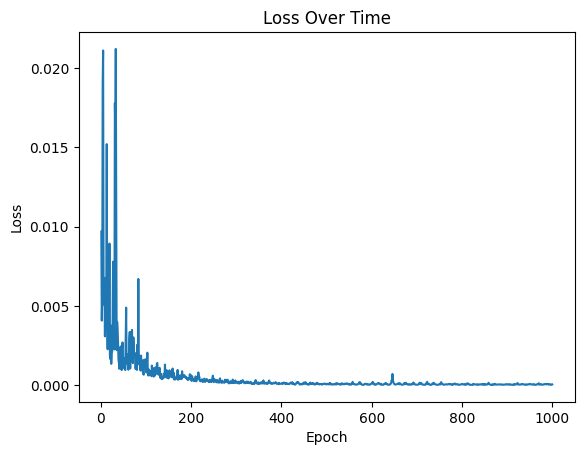

In [13]:
plt.plot(range(1, NUM_EPOCHS + 1), loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.show()


In [14]:
model_path = img_path + 'pos_encode_model.pt'
net.load_state_dict(torch.load(model_path))
net.eval()

FFN(
  (layers): Sequential(
    (0): Linear(in_features=2000, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=3, bias=True)
  )
)

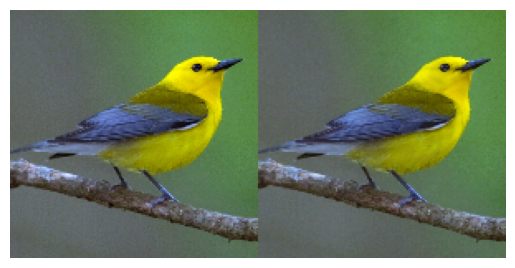

In [16]:
from torchvision.io import read_image


img = read_image(img_path+'image.png')

gt_image = torch.zeros(img.shape)
pred_image = torch.zeros(img.shape)

dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
with torch.no_grad():
  for batch in dataloader:
    x, y, intensity = batch["x"], batch["y"], batch["intensity"]
    gt_image[:, y.item(), x.item()] = intensity*255

    x_ = x / dataset.w # normalizing x between 0 and 1
    y_ = y / dataset.h # normalizing y between 0 and 1

    coord = torch.stack((x_, y_), dim=-1)
    pos_coord = pose_encod(B, coord.to(device))
    
    pred = net(pos_coord)

    pred_image[:, y.item(), x.item()] = pred * 255

pred_image = torch.clip(pred_image, 0, 255)

joint_image = torch.cat([gt_image.type(torch.uint8), pred_image.type(torch.uint8)], dim=2)
plt.imshow(joint_image.permute(1, 2, 0))
plt.axis('off')
plt.show()
plt.close()